# Model 2: Anatomically accurate model of Amygdala

1. target behavioral data
    - conditioned freezing
    - extinction-induced reduction of freezing
    - renewal of freezing when the CS is presented in the original context
2. target activity data
    - LA pyramidal neurons (PN) become CS-responsive after conditioning
    - LA pyramidal neurons (PN) maintain CS-responsiveness after extinction
    - LA inhibitory neurons (PV and SOM) respond to the US, releasing inhibition of LA pyramidal cells
    - BLA fear neurons (excitatory) become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons (excitatory) become CS-responsive after extinction
    - BLA persistent neurons (excitatory) become CS-responsive after conditioning and maintain their activity after extinction
    - CeL "on" neurons (inhibitory) become more responsive to CS following conditioning
    - CeL "off" neurons (inhibitory) become less responsive to CS following conditioning


In [2]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [3]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    
dt = 0.001
nCond = 5
nExt = 5
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 10
nCTX = 2
inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, seed=seed)
intercepts_pos = nengo.dists.Uniform(0, 1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_ctx = nengo.dists.Choice(inputs.CTXs)
intercepts_ctx = [(np.dot(inputs.CTXs, inputs.CTXs.T) - np.eye(nCTX)).flatten().max()]*dim_CTX*nNeurons
dInh = -2e0*np.ones((nNeurons, 1))

## Version 1
 - LA pyramidal and interneurons; functionally similar to model 1.1
 - PES learning updates connections weights from external_CS to LA_pyr, such that LA_pyr's CS response increases when the US is present alongside the CS
 - LA_inh receives CS and US information from external_CS and external_US via fixed connections, then gates learning in LA_pyr via inhibition

In [4]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_inh[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    nengo.Connection(external_US, LA_pyr[1])
    # error connections
    nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - (CS response)
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pError_LA = nengo.Probe(error_LA)

In [5]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


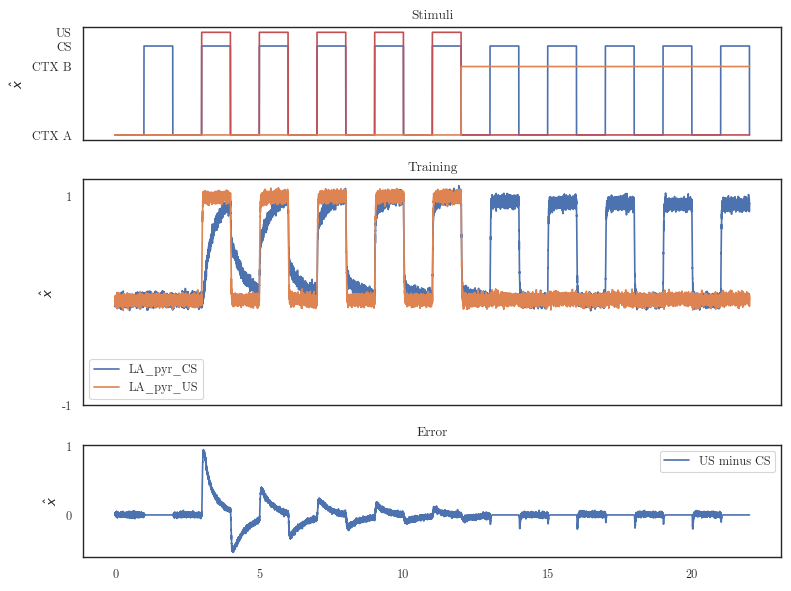

In [6]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,4,2]})
axes[0].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[0].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), ctx_signal, label="CTX")
axes[0].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr_CS")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="LA_pyr_US")
axes[1].legend()
axes[1].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[2].plot(sim.trange(), sim.data[pError_LA], label="US minus CS")
axes[2].legend()
axes[2].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

## Version 2
 - adds CeL and CeM. These populations convey LA_pyr output (learned CS responses) to the amygdala's output, causing freezing
 - PES learning updates connections weights from LA_pyr to CeL, such that CeL's CS response increases when the US is present alongside the CS
 - A constant bias is sent to CeM and to one dimension of CeL. This causes CeM, and some neurons in CeL, to fire without external input. These spontaneously active CeL cells inhibit CeM, such that, with no external input, CeM is quiet, and no freezing occurs
 - When CeL becomes conditioned to respond to CS via learned projections from LA, CS-responsive CeL neurons compete with spontaneously active CeL neurons to activate CeM, causing freezing. We realize this competition via a functional connection from CeL (CS-response minus bias); biologically, this likely happens through lateral inhibition in CeL and disinhibition of CeM.

In [33]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 0.4)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    ITC = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeL = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, bias]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_inh[1])
    nengo.Connection(external_US, CeL[1])
    nengo.Connection(bias, CeL[2])
    nengo.Connection(bias, CeM)
    # internal connections
    nengo.Connection(LA_pyr, ITC)  # transmit [CS response, US]
    nengo.Connection(CeL, CeM, function=lambda x: x[0]-x[2])
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    transmission = nengo.Connection(LA_pyr[0], CeL[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    # error connections
    nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(CeL, error_CeL, function=lambda x: x[1]-x[0])  # US - (CS response)
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    nengo.Connection(ITC, error_CeL.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_spikes = nengo.Probe(CeL.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pITC = nengo.Probe(ITC)
    pCeL = nengo.Probe(CeL)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)

In [34]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


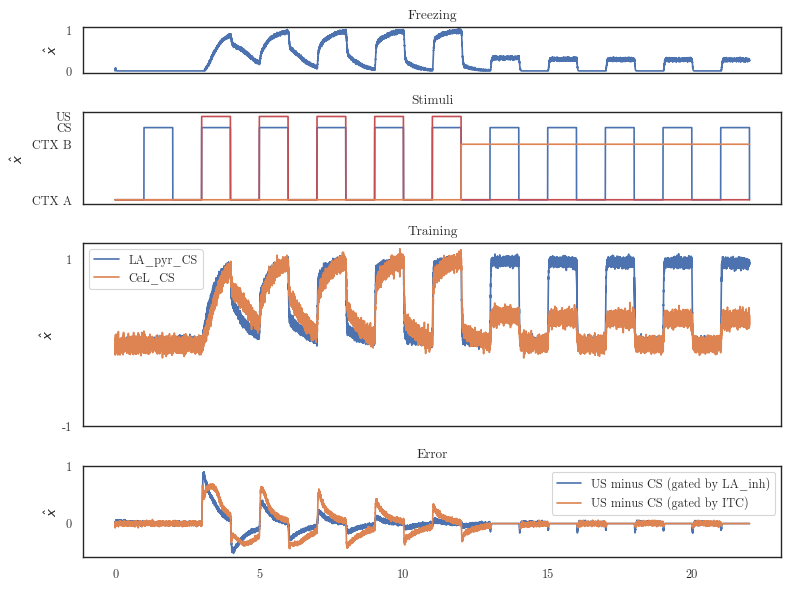

In [35]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pCeM])
axes[0].set(ylabel=r"$\hat{x}$", title="Freezing", yticks=((0,1)))
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr_CS")
axes[2].plot(sim.trange(), sim.data[pCeL][:,0], label="CeL_CS")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (gated by LA_inh)")
axes[3].plot(sim.trange(), sim.data[pError_CeL], label="US minus CS (gated by ITC)")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()